In [54]:
import torch 
import torchvision
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [36]:
from torchvision.datasets import CocoDetection
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from PIL import Image

In [69]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


# 1. LOAD THE DATASET IN COCO FORMAT

In [27]:
class FasterRCNNDataset(CocoDetection):
    def __init__(self, root, annFile, transforms=None):
        super().__init__(root, annFile)
        self.transforms = transforms

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        
        # Convert COCO bbox to [x1, y1, x2, y2]
        boxes = []
        labels = []
        for obj in target:
            x, y, w, h = obj['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(obj['category_id'])

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
            "image_id": torch.tensor([idx])
        }

        # Pass BOTH img and target to transforms
        if self.transforms:
            img, target = self.transforms(img, target)

        return img, target



In [ ]:
class ComposeTransforms:
    def __init__(self):
        self.to_tensor = transforms.ToTensor()
        self.resize =  transforms.Resize((224, 224)) 

    def __call__(self, img, target):
        # Convert only if it's a PIL image
        if isinstance(img, Image.Image):
            img = self.to_tensor(img)
        elif isinstance(img, torch.Tensor):
            pass  # already tensor
        else:
            raise TypeError(f"Unexpected image type: {type(img)}")
        return img, target

In [103]:
def collate_fn(batch):
    return tuple(zip(*batch))

transform = ComposeTransforms()

train_dataset = FasterRCNNDataset(
    root="../dataset/train",
    annFile="../dataset/train/_annotations.coco.json",
    transforms=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    collate_fn=collate_fn
)


loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


In [68]:
valid_dataset = FasterRCNNDataset(
    root="../dataset/valid",
    annFile="../dataset/valid/_annotations.coco.json",
    transforms=transform
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,          # no need to shuffle
    collate_fn=collate_fn
)

# --- Test dataset ---
test_dataset = FasterRCNNDataset(
    root="../dataset/test",
    annFile="../dataset/test/_annotations.coco.json",
    transforms=transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,          # no need to shuffle
    collate_fn=collate_fn
)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
imgs, targets = next(iter(train_loader))
print(imgs[0])
print(targets[0])


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
{'boxes': tensor([[511.0000, 242.0000, 572.6740, 490.0000],
        [465.0000, 250.0000, 543.1260, 461.0000],
        [280.0000, 222.0000, 414.6150, 466.0000]]), 'labels': tensor([2, 2, 2]), 'image_id': tensor([115

In [51]:
import matplotlib.patches as patches

In [58]:
class_names = ['vest-ppe', 'no_safety_vest','safety_vest']


In [66]:
i=3
img = imgs[i]
target = targets[i]

if isinstance(img, torch.Tensor):
    # Convert to H x W x C for matplotlib
    img = img.permute(1, 2, 0).numpy()

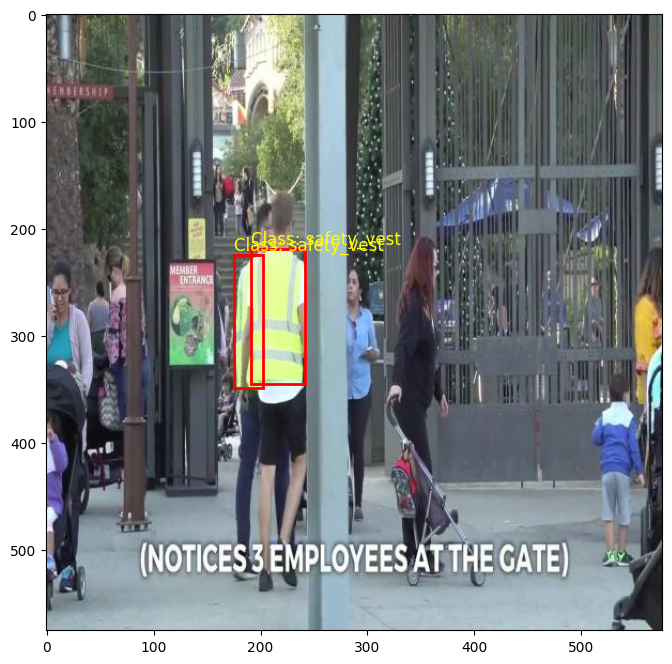

In [67]:
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(img)

boxes = target['boxes']
labels = target['labels']

for i, box in enumerate(boxes):
    x1, y1, x2, y2 = box
    width = x2 - x1
    height = y2 - y1
    rect = patches.Rectangle(
        (x1, y1), width, height,
        linewidth=2, edgecolor='r', facecolor='none'
    )
    ax.add_patch(rect)
    ax.text(x1, y1-5, f'Class: {class_names[labels[i].item()]}', color='yellow', fontsize=12)

plt.show()


# 2. Load the Faster R-CNN Model 

In [71]:
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model 

In [72]:
pretrained_model = get_model(3) 

/home/gomaa/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gomaa/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /home/gomaa/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:50<00:00, 3.32MB/s] 


In [73]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Device is {device}")

pretrained_model.to(device)

Device is cuda


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [75]:
params = [p for p in pretrained_model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [83]:
for imgs, targets in train_loader:
    print(imgs[0])
    print(targets[0])
    break

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0078, 0.0078],
         [0.0000, 0.0000, 0.0000,  ..., 0.0118, 0.0118, 0.0118],
         [0.0000, 0.0000, 0.0000,  ..., 0.0118, 0.0157, 0.0157]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

In [ ]:
# def train_one_epoch(model, optimizer, data_loader, device, epoch):
#     model.train()

#     for imgs, targets in data_loader:
#         images = list(imgs)
#         targets = list(targets)
#         images = [img.to(device) for img in imgs]
#         target = [{k: v.to(device) for k, v in t.items()} for t in targets]


#         # Forward prop
#         loss_dict = model(images, target)
#         losses = sum(loss for loss in loss_dict.values())        

#         # Backward prop
#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step()
    
#     print(f"Epoch {epoch} Loss: {losses.item():.4f}")
        

In [101]:
from tqdm import tqdm

In [109]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    total_loss = 0.0
    i = 1
    for imgs, targets in tqdm(data_loader):
        # Filter out images with no boxes
        filtered = [
            (img, t) for img, t in zip(imgs, targets)
            if t['boxes'].numel() > 0
        ]
        if len(filtered) == 0:
            continue  # skip this batch entirely if no valid images

        images, targets = zip(*filtered)
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward prop
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        total_loss += losses.item()

        
        # Backward prop
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if i%100 == 0:
            print(f"Passed {i} samples. ")
        i+=1

    print(f"Epoch {epoch} Loss: {total_loss:.4f}")

In [ ]:
print(len(train_loader))

13640


In [110]:
NUM_EPOCHS = 5
torch.cuda.empty_cache()
for epoch in tqdm(range(NUM_EPOCHS)):
     train_one_epoch(pretrained_model, optimizer,train_loader,device,epoch)
     lr_scheduler.step()

     model_path = f'models/fasterrcnn_resnet50_epoch_{epoch+1}.pth'
     torch.save(pretrained_model.state_dict(), model_path)
     print(f"Model saved: {model_path}")




  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:06<?, ?it/s]


KeyboardInterrupt: 